In [1]:
!nvidia-smi

Sat Nov 19 18:55:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    13W /  N/A |    155MiB /  8192MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
device = 'cuda:0'

In [3]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import torch

In [4]:
ref_video_path = Path('data/ref_video.mp4')
save_frames_path = Path('data/frames')
save_frames_path.mkdir(exist_ok=True, parents=True)

In [5]:
def read_video(file, n_frames=None):
    capture = cv2.VideoCapture(file)
    fps = capture.get(cv2.CAP_PROP_FPS)
    if n_frames is None:
        n_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)

    frames = []

    for _ in tqdm(np.arange(n_frames)):
        success, image_cv = capture.read()

        if not success:
            break

        frame = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame/255, dtype=torch.float32)
        frames.append(frame.permute(2,0,1)[None])

    return frames, fps, n_frames

In [6]:
frames, fps, n_frames = read_video(str(ref_video_path), 500)

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.23it/s]


# Preprocess data

In [4]:
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import torch

In [5]:
def torch_resize(img, scale_factor):
    width = int(img.shape[3] * scale_factor)
    height = int(img.shape[2] * scale_factor)
    dim = (height, width)
    
    resize_f = T.Resize(dim)

    # resize image
    resized = resize_f(img)
    return resized

In [6]:
scale_factor = 0.5

In [19]:
image1 = torch.tensor(np.array(Image.open('photo1.jpg')))/255.
image2 = torch.tensor(np.array(Image.open('photo2.jpg')))/255.
image3 = torch.tensor(np.array(Image.open('photo3.jpg')))/255.

image1 = image1.permute(2, 0, 1).unsqueeze(0)
image2 = image2.permute(2, 0, 1).unsqueeze(0)
image3 = image3.permute(2, 0, 1).unsqueeze(0)

image1 = torch_resize(image1, 0.5).to(device)
image2 = torch_resize(image2, 0.5).to(device)
image3 = torch_resize(image3, 0.5).to(device)
image2.shape

torch.Size([1, 3, 640, 640])

# Stitch by kornia stitcher

In [8]:
from kornia.contrib import ImageStitcher
import kornia.feature as KF
import kornia as K

IS = ImageStitcher(KF.LoFTR(pretrained='outdoor'), estimator='ransac').to(device)

In [20]:
with torch.inference_mode():
    out = IS(*[image1, image2])


In [21]:
with torch.inference_mode():
    out2 = IS(*[out, image3])


In [22]:
import matplotlib.pyplot as plt

In [23]:
out.shape, out2.shape

(torch.Size([1, 3, 640, 1280]), torch.Size([1, 3, 640, 1920]))

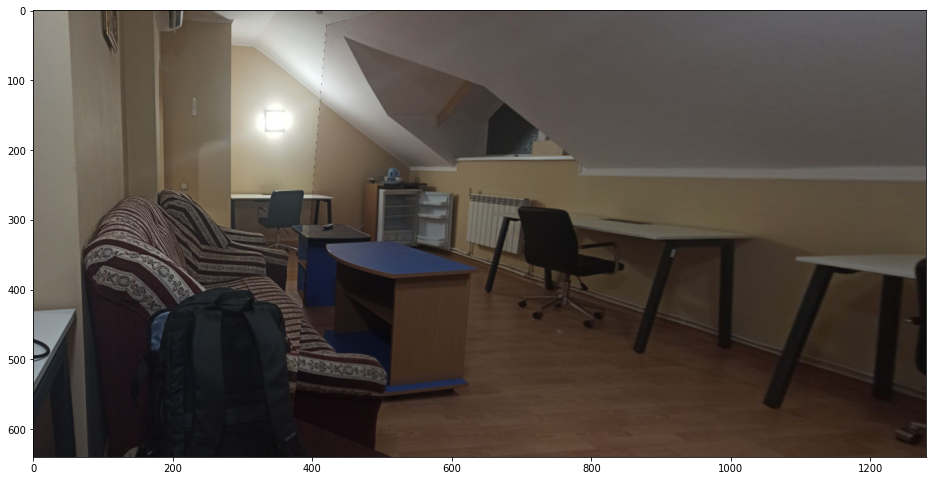

In [24]:
plt.figure(figsize=(16,16))
plt.imshow(out[0].permute(1, 2, 0).cpu())

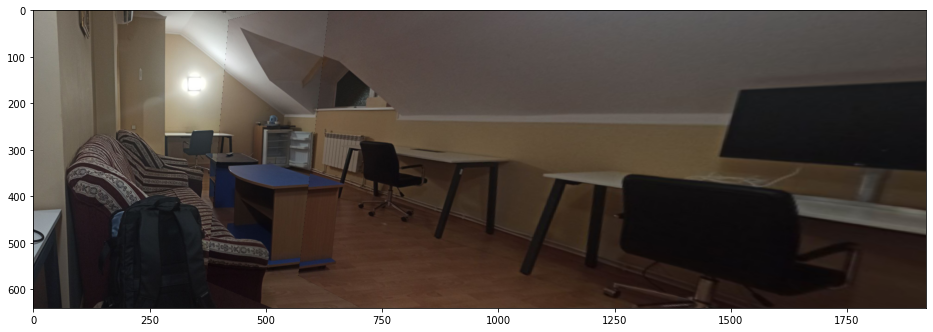

In [25]:
plt.figure(figsize=(16,16))
plt.imshow(out2[0].permute(1, 2, 0).cpu())